In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms.functional import normalize
#from google.colab import drive                # IF you are using COLAB

In [39]:
def extract_data(x_data_filepath, y_data_filepath):
    X = np.load(x_data_filepath)
    y = np.load(y_data_filepath)
    return X, y

In [40]:
############################################################
# Extracting and loading data
############################################################
class Dataset(Dataset):
    def __init__(self, X, y):
        self.len = len(X)           
        if torch.cuda.is_available():
            self.x_data = torch.from_numpy(X).float().cuda()
            self.y_data = torch.from_numpy(y).long().cuda()
        else:
            self.x_data = torch.from_numpy(X).float()
            self.y_data = torch.from_numpy(y).long()
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [41]:
def create_validation(x_train,y_train):
    """
    Randomly choose 20 percent of the training data as validation data.

    Args:
        x_train: training images in shape (num_images,3,image_H,image_W)
        y_train: training labels in shape (num_images,)
    Returns:
        new_x_train: training images in shape (0.8*num_images,3,image_H,image_W)
        new_y_train: training labels in shape (0.8*num_images,)
        x_val: validation images in shape (0.2*num_images,3,image_H,image_W)
        y_val: validation labels in shape (0.2*num_images,)
    """
    data = Dataset(x_train,y_train)
    train_size = int(np.floor(0.8* len(data)))
    indices= list(range(len(data)))
    valid_size = len(data) - train_size
    np.random.shuffle(indices)
    train_mapping=indices[valid_size:]
    valid_mapping=indices[:valid_size]
    new_x_train = data.x_data[train_mapping]
    x_val = data.x_data[valid_mapping]
    new_y_train = data.y_data[train_mapping]
    y_val = data.y_data[valid_mapping]
    
    return new_x_train,new_y_train,x_val,y_val

In [42]:
def normalize_image(image):
    """
    Normalize each input image

    Args:
        image: the input image in shape (3,image_H,image_W)
    Returns:
        norimg: the normalized image in the same shape as the input
    """
    np_x = image.numpy()
    # Mean per channel
    red_mean = np.mean(np_x[0,:,:])
    green_mean = np.mean(np_x[1,:,:])
    blue_mean = np.mean(np_x[2,:,:])
    # Standard Deviation per channel
    red_std = np.std(np_x[0,:,:])
    green_std = np.std(np_x[1,:,:])
    blue_std = np.std(np_x[2,:,:])
    # normalize in tensor
    np_x[0,:,:] = (np_x[0,:,:] - red_mean)/red_std
    np_x[1,:,:] = (np_x[1,:,:] - green_mean)/green_std
    np_x[2,:,:] = (np_x[2,:,:] - blue_mean)/blue_std
    norimg = torch.tensor(np_x)
    return norimg

In [83]:
############################################################
# Optimized Neural Network
############################################################
class OptimizedNN(nn.Module):
    
    def __init__(self):
        super(OptimizedNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3,stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3,stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3,stride=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(3072, 200)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(200, 5)
        self.dropout2 = nn.Dropout(p=0.2)
        
    
    def forward(self, x):
        # Normalisation
        x = normalize_image(x)
        out = F.relu(self.conv1(x))
        out = self.pool1(out)
        out = F.relu(self.conv2(out))
        out = self.pool2(out)
        out = F.relu(self.conv3(out))
        out = self.pool3(out)
        out = out.view(out.size(0),-1)
        out = self.dropout1(out)
        out = F.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.fc2(out)
        return out

In [44]:
def train_val_NN(neural_network, train_loader, validation_loader, loss_function, optimizer,num_epochs):
    """
    Runs experiment on the model neural network given a train loader, loss function and optimizer and find validation 
    accuracy for each epoch given the validation_loader.

    Args:
        neural_network (NN model that extends torch.nn.Module): For example, it should take an instance of either
                                                                FeedForwardNN or ConvolutionalNN,
        train_loader (DataLoader),
        validation_loader (DataLoader),
        loss_function (torch.nn.CrossEntropyLoss),
        optimizer (optim.SGD)
        num_epochs (number of iterations)
    Returns:
        tuple: First position, training accuracies of each epoch formatted in an array of shape (num_epochs,1).
               Second position, training loss of each epoch formatted in an array of shape (num_epochs,1).
               third position, validation accuracy of each epoch formatted in an array of shape (num_epochs,1).
               
    """
    accuracy = np.zeros(shape=(num_epochs,1))
    val_accuracy = np.zeros(shape=(num_epochs,1))
    loss_np = np.zeros(shape=(num_epochs,1))
    iterator = 0
    for epoch in range(1, num_epochs+1): ## run the model for 10 epochs
        train_loss = []
        ## training part 
        neural_network.train()
        correct = 0
        acc = 0
        val_acc = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            ## forward propagation
            output = neural_network(data)
            ## loss calculation
            loss = loss_function(output, target)
            ## backward propagation
            loss.backward()
            ## weight optimization
            optimizer.step()
            train_loss.append(loss.item())
            ## accuracy computation for each batch
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc = correct.item()/len(train_loader.dataset)
        ## evaluation part 
        neural_network.eval()
        correct = 0
        for data, target in validation_loader:
            output = neural_network(data)
            loss = loss_function(output, target)
            ## accuracy computation on validation set
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        val_acc=correct.item()/len(validation_loader.dataset)   
        # Add values for each epoch to the arrays
        accuracy[iterator] = acc
        val_accuracy[iterator] = val_acc
        loss_np[iterator] = np.mean(train_loss)
        iterator+=1
    
    return accuracy,loss_np,val_accuracy

In [84]:
############################################## Data Preprocessing #################################################

images, labels = extract_data('data/images_train.npy', 'data/labels_train.npy')
x_train, y_train, x_val, y_val = create_validation(images,labels)
train_dataset = torch.utils.data.TensorDataset(x_train,y_train)
validation_dataset = torch.utils.data.TensorDataset(x_val,y_val)
train_loader = DataLoader(train_dataset, batch_size=32)
validation_loader = DataLoader(validation_dataset, batch_size=32)

In [85]:
num_epochs = 40
optimized_nn = OptimizedNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(optimized_nn.parameters(), lr=0.001)
accuracy, loss_np, val_accuracy = train_val_NN(optimized_nn,train_loader, validation_loader, criterion, optimizer,num_epochs)


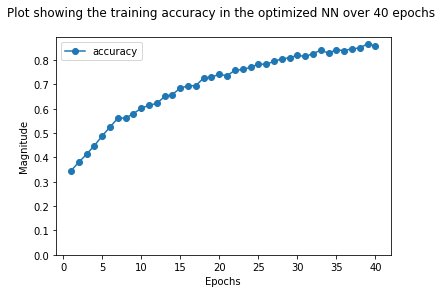

In [57]:
lst_acc = [accuracy[i].tolist()[0] for i in range(len(accuracy))]
epochs = [i+1 for i in range(num_epochs)]
f, ax = plt.subplots(1)
ax.plot(epochs, lst_acc,marker = 'o')
ax.set_ylim(bottom=0)
plt.title('Plot showing the training accuracy in the optimized NN over 40 epochs \n')
plt.xlabel('Epochs')
plt.ylabel('Magnitude')
plt.legend(['accuracy'])
plt.show(f)

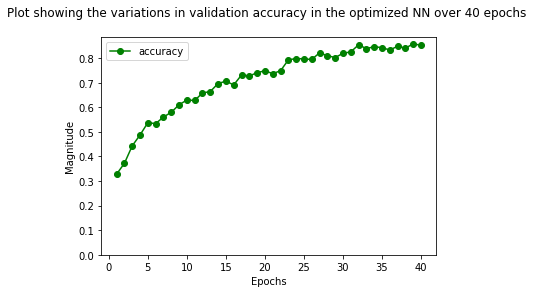

In [58]:
lst_val_acc = [val_accuracy[i].tolist()[0] for i in range(len(val_accuracy))]
epochs = [i+1 for i in range(num_epochs)]
f, ax = plt.subplots(1)
ax.plot(epochs, lst_val_acc, 'g',marker = 'o')
ax.set_ylim(bottom=0)
plt.title('Plot showing the variations in validation accuracy in the optimized NN over 40 epochs \n')
plt.xlabel('Epochs')
plt.ylabel('Magnitude')
plt.legend(['accuracy'])
plt.show(f)

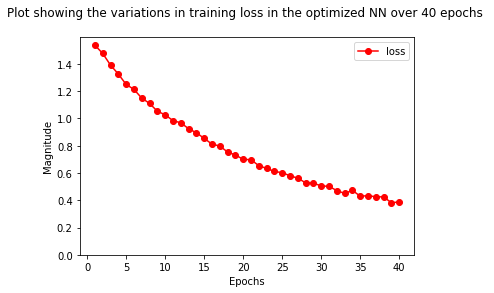

In [59]:
lst_loss = [loss_np[i].tolist()[0] for i in range(len(accuracy))]
epochs = [i+1 for i in range(num_epochs)]
f, ax = plt.subplots(1)
ax.plot(epochs, lst_loss, 'r', marker = 'o',)
ax.set_ylim(bottom=0)
plt.title('Plot showing the variations in training loss in the optimized NN over 40 epochs \n')
plt.xlabel('Epochs')
plt.ylabel('Magnitude')
plt.legend(['loss'])
plt.show(f)

In [60]:
print(accuracy[-1])
print(val_accuracy[-1])
print(loss_np[-1])

[0.85769231]
[0.85220729]
[0.38834045]


In [86]:
########################################## training on complete training data #######################################

def create_train(x_train,y_train):
    data = Dataset(x_train,y_train)
    train_size = int(np.floor(1.0* len(data)))
    indices= list(range(len(data)))
    valid_size = len(data) - train_size
    np.random.shuffle(indices)
    train_mapping=indices[valid_size:]
    valid_mapping=indices[:valid_size]
    new_x_train = data.x_data[train_mapping]
    x_val = data.x_data[valid_mapping]
    new_y_train = data.y_data[train_mapping]
    y_val = data.y_data[valid_mapping]
    
    return new_x_train,new_y_train,x_val,y_val

def train_NN(neural_network, train_loader, loss_function, optimizer,num_epochs):
    
    for epoch in range(1, num_epochs+1): ## run the model for 10 epochs
        train_loss = []
        ## training part 
        neural_network.train()
        correct = 0
        acc = 0
        val_acc = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            ## forward propagation
            output = neural_network(data)
            ## loss calculation
            loss = loss_function(output, target)
            ## backward propagation
            loss.backward()
            ## weight optimization
            optimizer.step()
            train_loss.append(loss.item())

images, labels = extract_data('data/images_train.npy', 'data/labels_train.npy')
x_train, y_train, x_val, y_val = create_validation(images,labels)
train_dataset = torch.utils.data.TensorDataset(x_train,y_train)
train_loader = DataLoader(train_dataset, batch_size=32)

train_NN(optimized_nn,train_loader,criterion, optimizer,num_epochs)

In [87]:
def test_NN(neural_network, test_loader):
  
    """
    Runs experiment on the model neural network given a test loader, loss function and optimizer.

    Args:
        neural_network (NN model that extends torch.nn.Module): For example, it should take an instance of either
                                                                FeedForwardNN or ConvolutionalNN,
        test_loader (DataLoader), (make sure the loader is not shuffled)
    Returns:
        your predictions         
    """
    neural_network.eval()
    Preds = torch.LongTensor()
    
    for _, data in enumerate(test_loader):
        data = data[0]
        output = neural_network(data)

        pred = output.data.max(1, keepdim=True)[1]
        Preds = torch.cat((Preds, pred), dim=0)

    return Preds

In [88]:
test_data = np.load('data/images_test.npy')
test_data = torch.tensor(test_data, dtype = torch.float32)
test_dataset = torch.utils.data.TensorDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=32)
Preds = test_NN(optimized_nn, test_loader)

In [89]:
test_loader

In [90]:
with open('HW4_preds.txt', 'w', encoding = 'utf8') as file:
    for i in range(len(test_loader.dataset)):
        file.write(str(Preds[i].item())+'\n')